In [10]:
# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from lib.datasets import CIFAR10_tf

%load_ext autoreload
%autoreload 2

print("TensorFlow Version {}".format(tf.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TensorFlow Version 1.14.0


In [11]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

data = CIFAR10_tf(num_training=num_training,
                  num_validation=num_validation,
                  num_test=num_test)

# Load cifar-10 data
X_train, Y_train = data['data_train'], data['labels_train']
X_val, Y_val = data['data_val'], data['labels_val']
X_test, Y_test = data['data_test'], data['labels_test']

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

In [12]:
# Define max pooling and conv layers

def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')


def flatten(input):
    """
        - input: input tensors
    """
    temp=tf.contrib.layers.flatten(input)
    return temp

def fc(input, num_output):
    """
        - input: input tensors
        - num_output: int, the output dimension
    """
    temp=tf.contrib.layers.fully_connected(input,num_output,activation_fn=None)
    return temp


## Sample convolutional neural network

In [13]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 64
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):

            self.conv2 = conv2d(self.pool1,5,1,64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)
            print('conv2 layer: ' + str(self.pool2.get_shape()))


        self.flat=flatten(self.pool2)
  
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            
            self.fc3=fc(self.flat,384)
            self.relu3 = tf.nn.relu(self.fc3)

            print('fc3 layer: ' + str(self.relu3.get_shape()))
            
        with tf.variable_scope('fc4'):

            self.fc4=fc(self.relu3,10)
            
            print('fc4 layer: ' + str(self.fc4.get_shape()))
            
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])


        self.step=tf.Variable(0)
        self.mode=tf.Variable(False)


    def _build_optimizer(self):

        self.train_op=tf.train.AdamOptimizer(tf.train.exponential_decay(learning_rate=5e-4,global_step=self.step,
                                             decay_steps=500,decay_rate=0.96),name="Adam").minimize(self.loss_op) 
     
        
    def _loss(self, labels, logits):
      
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,logits=logits ))
      

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                feed_dict = {self.X:X_,self.Y:Y_,self.step:step,self.mode:True}
              
                fetches = [self.train_op, self.loss_op, self.accuracy_op]
                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            
      
        # Graph 1. X: iteration (training step), Y: training loss   
        plt.title('Training Loss')
        plt.plot(list(range(0,step)),losses)
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.gcf().set_size_inches(8, 12)
        plt.show()

        # Graph 2. X: iteration (training step), Y: training accuracy
        plt.title('Training Accuracy')
        plt.plot(list(range(0,step)),accuracies)
        plt.xlabel('Step')
        plt.ylabel('Accuracy')
        plt.gcf().set_size_inches(15, 12)
        plt.show()
     

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            
          
            feed_dict = {self.X:X_,self.Y:Y_,self.mode:False}
       
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

In [ ]:
tf.reset_default_graph()

# Train Base Model
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    with tf.device('/GPU:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 16.782, accuracy = 0.125
iteration (50): loss = 1.953, accuracy = 0.297
iteration (100): loss = 1.805, accuracy = 0.359
iteration (150): loss = 1.880, accuracy = 0.328
iteration (200): loss = 1.447, accuracy = 0.469
iteration (250): loss = 1.570, accuracy = 0.422
iteration (300): loss = 1.720, accuracy = 0.312
iteration (350): loss

In [ ]:
# ACCURACY 73 percent model

class BetterModel(BaseModel):
    def __init__(self):
        super(BetterModel, self).__init__()
        self.num_epoch = 25

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)
        
        print('input layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)
            
            maxi=tf.reduce_max(self.pool1)
            mini=tf.reduce_min(self.pool1)
            self.pool1=(self.pool1-mini)/(maxi-mini)
            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            self.conv2 = conv2d(self.pool1,5,1,64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)
            
            print('conv2 layer: ' + str(self.pool2.get_shape()))
        
        with tf.variable_scope('conv3'):
            self.conv3 = conv2d(self.pool2,3,1,32)
            self.relu3 = tf.nn.relu(self.conv3)
            self.pool3 = max_pool(self.relu3, 3, 2)
           
            print('conv3 layer: ' + str(self.pool3.get_shape()))    

        self.flat=flatten(self.pool3)    
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            self.fc3=fc(self.flat,384)
#             self.fc3=tf.nn.dropout(self.fc3,0.95)
            self.relu3 = tf.nn.relu(self.fc3)
            print('fc3 layer: ' + str(self.relu3.get_shape()))
            
        with tf.variable_scope('fc4'):
#             self.fc4=tf.nn.dropout(self.relu3,0.75)
            self.fc4=fc(self.relu3,10)
            print('fc4 layer: ' + str(self.fc4.get_shape()))
            
        # Return the last layer
        return self.fc4

-----  Sample model  -----
input layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 32)
flat layer: (?, 512)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 2.311, accuracy = 0.016
iteration (50): loss = 1.831, accuracy = 0.328
iteration (100): loss = 1.851, accuracy = 0.375
iteration (150): loss = 1.722, accuracy = 0.344
iteration (200): loss = 1.522, accuracy = 0.453
iteration (250): loss = 1.584, accuracy = 0.438
iteration (300): loss = 1.546, accuracy = 0.391
iteration (350): loss = 1.434, accuracy = 0.484
iteration (400): loss = 1.340, accuracy = 0.531
iteration (450): loss = 1.306, accuracy = 0.641
iteration (500): loss = 1.417, accuracy = 0.516
iteration (550): loss = 1.150, accuracy = 0.547
iteration (600): loss = 1.397, accuracy = 0.547
iteration (650): loss = 1.241, accuracy = 0.484
iteration (700): loss = 1.384, accuracy = 0.516
iteration (750): loss = 1.748, accurac

-  epoch 5: validation accuracy = 0.710
train for epoch 6
iteration (4600): loss = 0.874, accuracy = 0.688
iteration (4650): loss = 0.777, accuracy = 0.703
iteration (4700): loss = 0.924, accuracy = 0.703
iteration (4750): loss = 0.740, accuracy = 0.719
iteration (4800): loss = 0.626, accuracy = 0.844
iteration (4850): loss = 0.798, accuracy = 0.766
iteration (4900): loss = 0.848, accuracy = 0.672
iteration (4950): loss = 0.767, accuracy = 0.750
iteration (5000): loss = 0.881, accuracy = 0.656
iteration (5050): loss = 0.655, accuracy = 0.797
iteration (5100): loss = 0.582, accuracy = 0.781
iteration (5150): loss = 0.454, accuracy = 0.828
iteration (5200): loss = 0.742, accuracy = 0.719
iteration (5250): loss = 0.483, accuracy = 0.859
iteration (5300): loss = 0.687, accuracy = 0.719
iteration (5350): loss = 0.437, accuracy = 0.844
validation for epoch 6
-  epoch 6: validation accuracy = 0.724
train for epoch 7
iteration (5400): loss = 0.531, accuracy = 0.781
iteration (5450): loss = 0.7

iteration (12100): loss = 0.428, accuracy = 0.844
iteration (12150): loss = 0.404, accuracy = 0.906
iteration (12200): loss = 0.324, accuracy = 0.891
validation for epoch 15
-  epoch 15: validation accuracy = 0.747
train for epoch 16
iteration (12250): loss = 0.542, accuracy = 0.797
iteration (12300): loss = 0.415, accuracy = 0.844
iteration (12350): loss = 0.624, accuracy = 0.797
iteration (12400): loss = 0.436, accuracy = 0.891
iteration (12450): loss = 0.384, accuracy = 0.891
iteration (12500): loss = 0.553, accuracy = 0.812
iteration (12550): loss = 0.613, accuracy = 0.781
iteration (12600): loss = 0.427, accuracy = 0.891
iteration (12650): loss = 0.475, accuracy = 0.844
iteration (12700): loss = 0.328, accuracy = 0.891
iteration (12750): loss = 0.375, accuracy = 0.906
iteration (12800): loss = 0.205, accuracy = 0.953
iteration (12850): loss = 0.483, accuracy = 0.859
iteration (12900): loss = 0.247, accuracy = 0.922
iteration (12950): loss = 0.414, accuracy = 0.844
iteration (13000

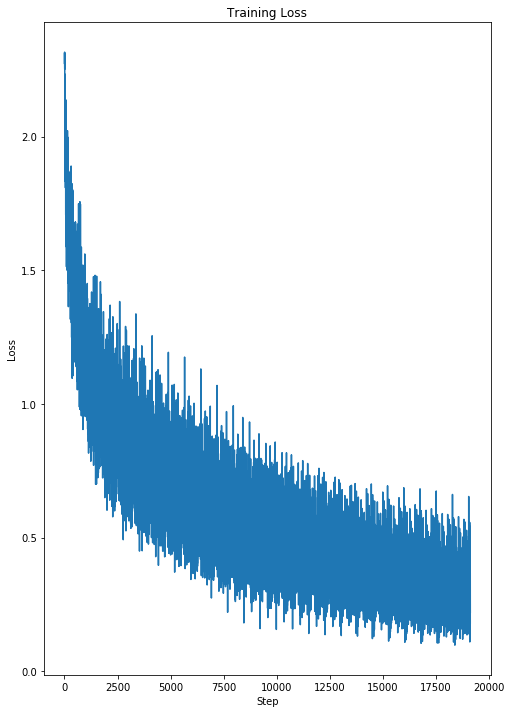

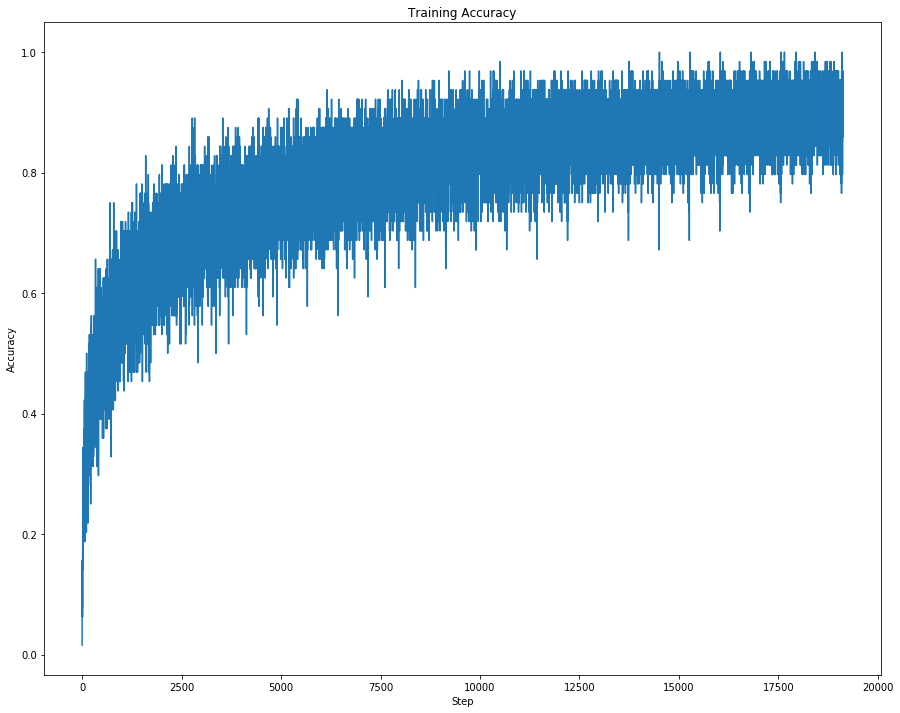

***** test accuracy: 0.751
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [17]:
# Clear old computation graphs
tf.reset_default_graph()

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    with tf.device('/cpu:0'):
        model = BetterModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
#         Save your model
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
        print("Model saved in %s" % model_path)

In [18]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")

-----  Sample model  -----
input layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 32)
flat layer: (?, 512)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt
